In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns
import optuna

pd.options.mode.chained_assignment = None 

## Loading data

In [2]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -o titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
df_train_all = pd.read_csv('./train.csv')
df_train, df_test = train_test_split(df_train_all, test_size=0.2, random_state=42)

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


## Description of features

| Name | Description | Info |
| --- | --- | --- |
| PassengerId | id |
| Survived | Survival | 0 = No, 1 = Yes |
| Pclass | Ticket   | class 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex	 |Sex	
| Age | Age in years |
| SibSp | number of siblings / spouses aboard the Titanic |
|Parch | number of parents / children aboard the Titanic |
| Fare | Passenger fare |
| Ticket | Ticket number |
| Cabin | Cabin number |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

I try to create model which predicts survivability on Titanic using gradient boosting trees with lightgbm implementaition.

## Data analysis

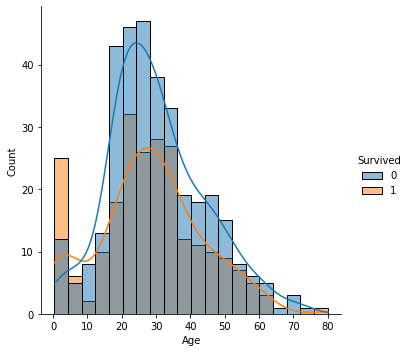

In [6]:
sns.displot(df_train, x='Age', hue='Survived', kde=True)

Younger peaple have higher chance for survive

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

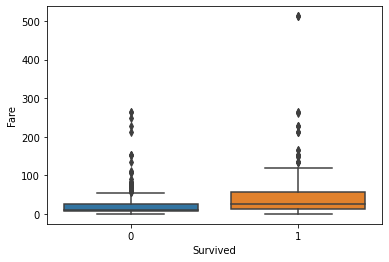

In [7]:
sns.boxplot(y='Fare', x='Survived', data=df_train)

Also ticket price could correlate with survivability.

/home/azapala/.local/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


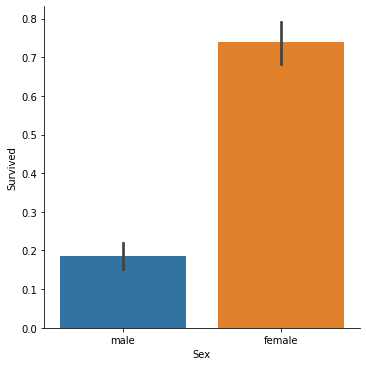

In [8]:
sns.factorplot(data=df_train, x="Sex", y="Survived", kind="bar")

In [9]:
df_train.groupby('Sex').size()

Sex
female    245
male      467
dtype: int64

Is gender equality an idea of the 21st century? Women have much higher survability.

/home/azapala/.local/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


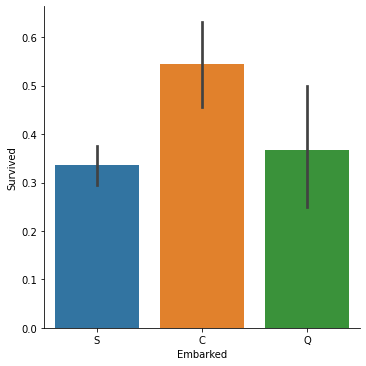

In [10]:
sns.factorplot(data=df_train, x="Embarked", y="Survived", kind="bar")

In [11]:
df_train.groupby('Embarked').size()

Embarked
C    125
Q     60
S    525
dtype: int64

Ports of embarakation have diffrent survability. Maybe there is a hidden correlection. 

In [12]:
df_train.Age.nunique()

83

In [13]:
df_train.Fare.nunique()

220

In [14]:
df_train.groupby(['SibSp', 'Parch']).size().to_frame(name='counts')

counts
SibSp Parch        
0     0         429
      1          31
      2          21
      3           1
      4           1
      5           1
1     0          96
      1          44
      2          18
      3           1
      4           2
      5           2
      6           1
2     0          14
      1           5
      2           3
      3           1
3     0           2
      1           6
      2           5
4     1           8
      2           8
5     2           5
8     2           7

Age and fare are a categorical features. SibSp, Parch could be treat as categorical or continous features 

## Add simple features

In [15]:
for df in [df_train, df_test, df_train_all]:
    df['FamilySize'] = 0 
    df.loc[:, 'FamilySize'] =  df['Parch'] + df['SibSp']
    df.loc['Single'] = 0
    df.loc[df['FamilySize'] > 0, 'Single'] = 1

In [16]:
for df in [df_train, df_test, df_train_all]:
    df['AgeGroup'] = "baby"
    df.loc[(df.Age > 5) & (df.Age <= 14),'AgeGroup'] = "teenager"
    df.loc[(df.Age > 14) & (df.Age <= 60), 'AgeGroup' ] = "adult"
    df.loc[(df.Age > 60), 'AgeGroup' ] = "old"    

In [17]:
model_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Single', 'AgeGroup']

countinous_columns = ['Age', 'Parch', 'SibSp', 'FamilySize']
cat_columns = [col for col in model_columns if col not in countinous_columns]

In [18]:
for dataset in [df_test, df_train, df_train_all]:
    dataset[cat_columns] = dataset[cat_columns].astype('category')

In [19]:
df_train[model_columns].dtypes

Pclass        category
Sex           category
Age            float64
SibSp            int64
Parch            int64
Fare          category
Embarked      category
FamilySize       int64
Single        category
AgeGroup      category
dtype: object

## Trening

In [20]:
def generate_lgb_dataset(df, model_columns, target_columns_name):
    return lgb.Dataset(df[model_columns], label=df[target_columns_name])

In [21]:
d_train = generate_lgb_dataset(df_train, model_columns, 'Survived')
d_test =  generate_lgb_dataset(df_test, model_columns, 'Survived')

params={
    'application': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'verbose': -1
}

### CV

In [22]:
history = lgb.cv(params, d_train, num_boost_round=30, nfold=5)

Mean auc metric based on 5-fold cross validation:

In [23]:
history['auc-mean'][-1]

0.853826192102639

Text(0, 0.5, 'Mean auc')

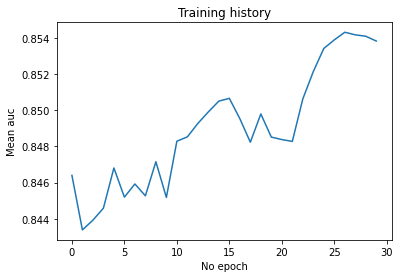

In [24]:
plt.plot(history['auc-mean'])
plt.title('Training history')
plt.xlabel('No epoch')
plt.ylabel('Mean auc')

### test set

In [25]:
def train_and_evaluate(params, d_train, d_test):
    history = {}
    bst = lgb.train(params, d_train, valid_sets=[d_train, d_test], valid_names=['train', 'test'], evals_result=history, num_boost_round=30)
    
    plt.plot(history['train']['auc'])
    plt.plot(history['test']['auc'])
    plt.title('History of training')
    plt.xlabel('epoch')
    plt.ylabel('auc')
    plt.legend(['train','test'])
    plt.show()
    
    print(f"AUC: {history['test']['auc'][-1]}")

/home/azapala/.local/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/azapala/.local/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	train's auc: 0.888823	test's auc: 0.854347
[2]	train's auc: 0.890638	test's auc: 0.855877
[3]	train's auc: 0.894147	test's auc: 0.858108
[4]	train's auc: 0.894462	test's auc: 0.857853
[5]	train's auc: 0.896197	test's auc: 0.855367
[6]	train's auc: 0.898889	test's auc: 0.859128
[7]	train's auc: 0.899832	test's auc: 0.859128
[8]	train's auc: 0.900805	test's auc: 0.858873
[9]	train's auc: 0.903836	test's auc: 0.866331
[10]	train's auc: 0.906427	test's auc: 0.869901
[11]	train's auc: 0.908356	test's auc: 0.874108
[12]	train's auc: 0.908901	test's auc: 0.874363
[13]	train's auc: 0.909672	test's auc: 0.875
[14]	train's auc: 0.911492	test's auc: 0.874426
[15]	train's auc: 0.913362	test's auc: 0.876466
[16]	train's auc: 0.913953	test's auc: 0.873853
[17]	train's auc: 0.914523	test's auc: 0.873534
[18]	train's auc: 0.915278	test's auc: 0.874235
[19]	train's auc: 0.915974	test's auc: 0.876657
[20]	train's auc: 0.920665	test's auc: 0.880801
[21]	train's auc: 0.923323	test's auc: 0.880801
[22]

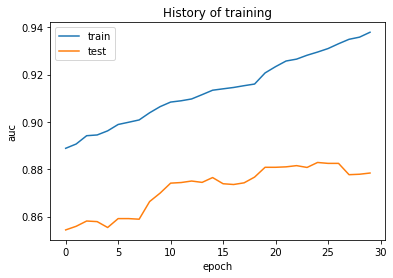

AUC: 0.8783783783783784


In [26]:
train_and_evaluate(params, d_train, d_test)

Auc metric of our model is relatively high. History of training doesn't indicate on overfitting. 

## HP tuning

In [27]:
d_train = generate_lgb_dataset(df_train, model_columns, 'Survived') # different hps change inner option of dataset, we can't reuse datasets for training
hp_tuner = optuna.integration.lightgbm.LightGBMTunerCV(params, d_train, num_boost_round=30, study=optuna.create_study(study_name='automatic-fine-tuning', direction='maximize'), verbose_eval=0, return_cvbooster=True)

[I 2021-03-11 19:29:59,429] A new study created in memory with name: automatic-fine-tuning


In [28]:
hp_tuner.run()

bagging, val_score: 0.864894:  40%|####      | 4/10 [00:01<00:01,  3.20it/s][I 2021-03-11 19:30:06,047] Trial 30 finished with value: 0.8545061597531388 and parameters: {'bagging_fraction': 0.8172888466355681, 'bagging_freq': 3}. Best is trial 28 with value: 0.8648937256102828.


regularization_factors, val_score: 0.867170:  85%|########5 | 17/20 [00:02<00:00,  7.18it/s][I 2021-03-11 19:30:09,603] Trial 56 finished with value: 0.8633610502595026 and parameters: {'lambda_l1': 1.3566124725907254e-05, 'lambda_l2': 8.847069447367478}. Best is trial 42 with value: 0.8671699683571635.


min_data_in_leaf, val_score: 0.867170: 100%|##########| 5/5 [00:00<00:00,  8.48it/s]


In [29]:
hp_tuner.best_score

0.8671699683571635

Tuning hyper parameter slightly improve (~0.01) mean auc score on cross validation.

In [30]:
params = hp_tuner.best_params

/home/azapala/.local/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/azapala/.local/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	train's auc: 0.859412	test's auc: 0.860084
[2]	train's auc: 0.859412	test's auc: 0.860084
[3]	train's auc: 0.859412	test's auc: 0.860084
[4]	train's auc: 0.859186	test's auc: 0.859638
[5]	train's auc: 0.860922	test's auc: 0.864164
[6]	train's auc: 0.861173	test's auc: 0.864674
[7]	train's auc: 0.86358	test's auc: 0.869773
[8]	train's auc: 0.863253	test's auc: 0.869518
[9]	train's auc: 0.867856	test's auc: 0.875064
[10]	train's auc: 0.867797	test's auc: 0.875829
[11]	train's auc: 0.880522	test's auc: 0.877868
[12]	train's auc: 0.880823	test's auc: 0.877741
[13]	train's auc: 0.881649	test's auc: 0.878825
[14]	train's auc: 0.882018	test's auc: 0.873725
[15]	train's auc: 0.881662	test's auc: 0.87296
[16]	train's auc: 0.883645	test's auc: 0.873598
[17]	train's auc: 0.884282	test's auc: 0.874171
[18]	train's auc: 0.884852	test's auc: 0.874426
[19]	train's auc: 0.886077	test's auc: 0.871558
[20]	train's auc: 0.886177	test's auc: 0.871303
[21]	train's auc: 0.88567	test's auc: 0.870984
[22]

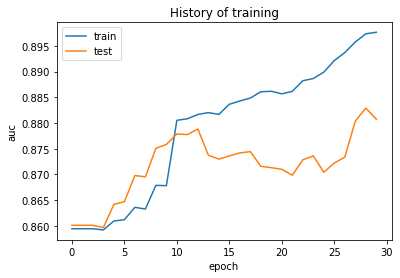

AUC: 0.8807368689444162


In [31]:
d_train = generate_lgb_dataset(df_train, model_columns, 'Survived')
d_test = generate_lgb_dataset(df_test, model_columns, 'Survived')
train_and_evaluate(params, d_train, d_test)

Also metrics on test dataset is slightly better. Autotuning  of hyperparameters improves prediction of our model.